# Example development notebook for `app_predict`

Related wiki page:  
https://github.com/stharrold/demo/wiki/app_predict

In [1]:
cd /opt/demo

/opt/demo


In [2]:
# Import standard packages.
import os
import sys
import time
# Import installed packages.
# Import local packages.
sys.path.insert(0, os.path.join(os.path.curdir, r'demo'))
%reload_ext autoreload
%autoreload 2
import demo
%matplotlib inline

In [3]:
print("Timestamp:")
print(time.strftime(r'%Y-%m-%dT%H:%M:%S%Z', time.gmtime()))
print()
print("Versions:")
print("Python:", sys.version_info)
print("demo:", demo.__version__)

Timestamp:
2017-02-25T05:05:05GMT

Versions:
Python: sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)
demo: 0.0.0


In [4]:
!py.test -v --pdb

============================= test session starts ==============================
platform linux -- Python 3.5.2, pytest-2.9.2, py-1.4.31, pluggy-0.3.1 -- /opt/conda/bin/python
cachedir: .cache
rootdir: /opt/demo, inifile: 
collected 8 items 

tests/test__init__.py::test__all__ PASSED
tests/test__init__.py::test__version__ PASSED
tests/test_app_template/test_app_template__init__.py::test__all__ PASSED
tests/test_app_template/test_app_template_main.py::test__all__ PASSED
tests/test_app_template/test_app_template_main.py::test_main PASSED
tests/test_app_template/test_app_template_main.py::test__main__ PASSED
tests/test_app_template/test_template.py::test_prepend_this PASSED
tests/test_utils/test_utils__init__.py::test__all__ PASSED

=========================== 8 passed in 4.73 seconds ===========================


# Development below

## Initialization

### Imports

In [1]:
cd /opt/demo

/opt/demo


In [184]:
# Import standard packages.
import bs4
import collections
import glob
import io
import os
import pickle
import requests
import subprocess
import sys
import textwrap
import time
import warnings
# Import installed packages.
import geopy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn as sk
import sklearn.cross_validation as sk_cv
import sklearn.cluster as sk_cl
import sklearn.decomposition as sk_dc
import sklearn.ensemble as sk_ens
import sklearn.metrics as sk_met
import sklearn.preprocessing as sk_pre
# Import local packages.
# datascience version: TODO link to GitHub tag v0.0.1.
sys.path.insert(0, os.path.join(os.path.curdir, r'demo'))
%reload_ext autoreload
%autoreload 2
import demo
%matplotlib inline

In [185]:
print("Timestamp:")
print(time.strftime(r'%Y-%m-%dT%H:%M:%S%Z', time.gmtime()))
print()
print("Versions:")
print("Python:", sys.version_info)
print("matplotlib:", mpl.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scipy:", scipy.__version__)
print("sklearn:", sk.__version__)
print("seaborn:", sns.__version__)
print("demo:", demo.__version__)

Timestamp:
2017-02-25T21:54:28GMT

Versions:
Python: sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)
matplotlib: 1.5.1
numpy: 1.11.1
pandas: 0.18.1
scipy: 0.17.1
sklearn: 0.17.1
seaborn: 0.7.1
demo: 0.0.0


In [186]:
# State settings.
sns.set() # Set matplot lib styles with seaborn
np.random.seed(seed=1) # Set random state for reproducibility.

# File paths
path_data_dir = os.path.join(os.path.abspath(os.path.curdir), r'demo/app_predict/data')
path_csv = os.path.join(path_data_dir, r'Risky Dealer Case Study Transactions.csv')

# Statistics
# percentiles = [-1.6449 sigma, -1 sigma, mean, +1 sigma, +1.6449 sigma] for normal distribution
# 90.00% confidence interval = (percentiles[0], percentiles[-1])
# 68.27% confidence interval = (percentiles[1], percentiles[-2])
# median = percentiles[2]
percentiles = [0.0500, 0.1587, 0.5000, 0.8413, 0.9500]

## Extract, transform, and load

In [187]:
print(r"""`df`: Load and format sales transactions.""")
df = pd.read_csv(path_csv)

`df`: Load and format sales transactions.


In [188]:
df.head()

,BuyerID,SellerID,Mileage,VIN,SellingLocation,CarMake,SalePrice,CarYear,MMR,JDPowersCat,...,Salvage,OVE,Simulcast,InLane,PSIEligible,SaleDate,Autocheck_score,ConditionReport,DSEligible,Returned
0,351757,441081,37055,1FAHP3M27CL374352,CAAI,FORD,13000,2012,13050,COMPACT CAR,...,0,0,0,0,1,13-07-25,1.000000,NaN,1,0.0
1,351757,442235,248,1G1JE6SB7D4103706,DETA,CHEVROLET,13900,2013,13600,COMPACT CAR,...,0,0,0,0,1,13-10-24,NaN,NaN,1,NaN
2,351757,436280,39627,1G1PG5SC4C7102274,CAAI,CHEVROLET,13800,2012,14050,MIDSIZE CAR,...,0,0,0,1,1,13-04-18,-2.666667,41,1,NaN
3,351757,436280,50773,1G1PG5SC5C7113820,CAAI,CHEVROLET,12900,2012,13150,MIDSIZE CAR,...,0,0,0,1,1,13-04-18,1.000000,31,1,NaN
4,351757,434202,54133,1GNKVGED4BJ301146,SVAA,CHEVROLET,17800,2011,18050,SUV,...,0,0,0,1,1,13-02-26,-1.400000,34,1,NaN


## Exploratory data analysis

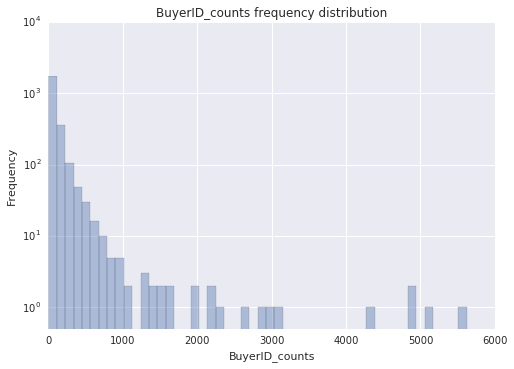

In [7]:
# BuyerID, BuyerId_counts

# Cast BuyerID to string.
df['BuyerID'] = df['BuyerID'].astype(str)

# Plot frequency distrbution and save as feature.
buyerid_counts = collections.Counter(df['BuyerID'].values)
df['BuyerID_counts'] = df['BuyerID'].map(buyerid_counts)
sns.distplot(list(buyerid_counts.values()), hist=True, kde=False, norm_hist=False)
plt.title('BuyerID_counts frequency distribution')
plt.xlabel('BuyerID_counts')
plt.ylabel('Frequency')
plt.yscale('log')
plt.ylim(ymin=0.5)
plt.show()

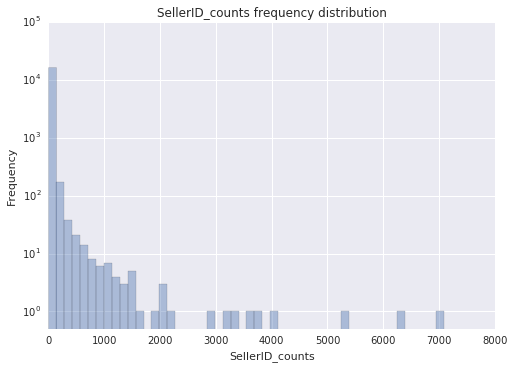

In [8]:
# SellerID, SellerID_counts
# Cast SellerID to string.
df['SellerID'] = df['SellerID'].astype(str)
# Plot frequency distrbution and save as feature.
sellerid_counts = collections.Counter(df['SellerID'].values)
df['SellerID_counts'] = df['SellerID'].map(sellerid_counts)
sns.distplot(list(sellerid_counts.values()), hist=True, kde=False, norm_hist=False)
plt.title('SellerID_counts frequency distribution')
plt.xlabel('SellerID_counts')
plt.ylabel('Frequency')
plt.yscale('log')
plt.ylim(ymin=0.5)
plt.show()

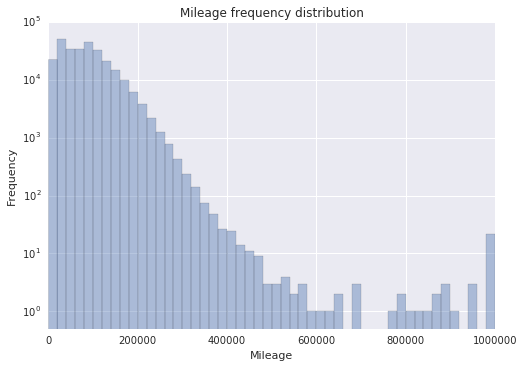

In [9]:
# Mileage
# Plot frequency distribution.
sns.distplot(df['Mileage'].values, hist=True, kde=False, norm_hist=False)
plt.title('Mileage frequency distribution')
plt.xlabel('Mileage')
plt.ylabel('Frequency')
plt.yscale('log')
plt.ylim(ymin=0.5)
plt.show()

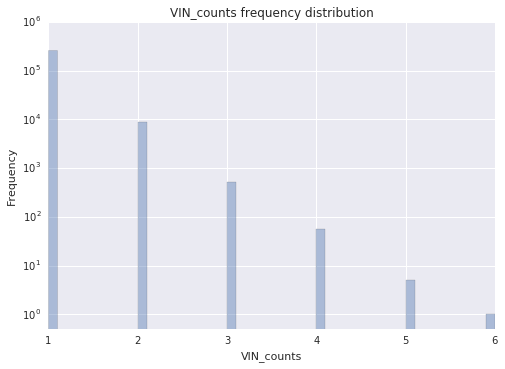

In [10]:
# VIN, VIN_counts
# Plot frequency distrbution and save as feature.
vin_counts = collections.Counter(df['VIN'].values)
df['VIN_counts'] = df['VIN'].map(vin_counts)
sns.distplot(list(vin_counts.values()), hist=True, kde=False, norm_hist=False)
plt.title('VIN_counts frequency distribution')
plt.xlabel('VIN_counts')
plt.ylabel('Frequency')
plt.yscale('log')
plt.ylim(ymin=0.5)
plt.show()

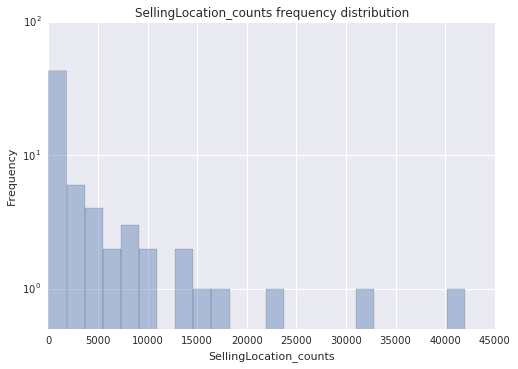

In [11]:
# SellingLocation, SellingLocation_counts, SellingLocation_lat, SellingLocation_lon, SellingLocation_<loc>
# Cell takes ~1 min to execute.

# Extract counts.
sellloc_counts = collections.Counter(df['SellingLocation'].values)
df['SellingLocation_counts'] = df['SellingLocation'].map(sellloc_counts)
sns.distplot(list(sellloc_counts.values()), hist=True, kde=False, norm_hist=False)
plt.title('SellingLocation_counts frequency distribution')
plt.xlabel('SellingLocation_counts')
plt.ylabel('Frequency')
plt.yscale('log')
plt.ylim(ymin=0.5)
plt.show()

# Scrape webpages for first address to match SellingLocation code.
try:
    sellloc_geoloc
except NameError:
    sellloc_geoloc = dict()
    seconds_per_query = 1.0/5.0 # Google API limit
    for loc in df['SellingLocation'].unique():
        url = r'https://www.manheim.com/locations/{loc}/events'.format(loc=loc)
        page = requests.get(url)
        tree = bs4.BeautifulSoup(page.text, 'lxml')
        address = tree.find(name='p', class_='loc_address').get_text().strip()
        try:
            components = {
                'country': 'United States',
                'postal_code': address.split()[-1]}
            location = geopy.geocoders.GoogleV3().geocode(
                query=address,
                exactly_one=True,
                components=components)
        except:
            warnings.warn(textwrap.dedent("""\
                Exception raised. Setting {loc} geo location to `None`
                sys.exc_info() =
                {exc}""".format(loc=loc, exc=sys.exc_info())))
            location = None
        sellloc_geoloc[loc] = location
        time.sleep(seconds_per_query)
# Map SellingLocation codes to latitude, longitude coordinates.
sellloc_lat = {
    sellloc: (geoloc.latitude if geoloc is not None else 0.0)
    for (sellloc, geoloc) in sellloc_geoloc.items()}
sellloc_lon = {
    sellloc: (geoloc.longitude if geoloc is not None else 0.0)
    for (sellloc, geoloc) in sellloc_geoloc.items()}
df['SellingLocation_lat'] = df['SellingLocation'].map(sellloc_lat)
df['SellingLocation_lon'] = df['SellingLocation'].map(sellloc_lon)

# One-hot encoding.
df = pd.merge(
    left=df,
    right=pd.get_dummies(df['SellingLocation'], prefix='SellingLocation'),
    how='inner',
    left_index=True,
    right_index=True)

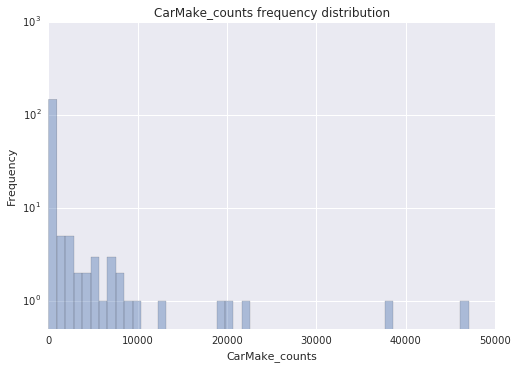

In [12]:
# CarMake, one-hot encoding
# TODO: Find/scrape hierarchical relationships between car brands
# (e.g. https://en.wikipedia.org/wiki/Category:Mid-size_cars). To business people: would that be helpful?
# TODO: Deduplicate with spelling corrector.

# Deduplicate CarMake.
carmake_dedup = {
    '1SUZU': 'ISUZU',
    'CHEVY': 'CHEVROLET',
    'XHEVY': 'CHEVROLET',
    'DAMON': 'DEMON',
    'FORESTR':'FORESTRIVER',
    'FORESTRIVE': 'FORESTRIVER',
    'FREIGHTLI': 'FREIGHTLINER',
    'FREIGHTLIN': 'FREIGHTLINER',
    'FRIGHTLIE': 'FREIGHTLINER',
    'FRTLNRL': 'FREIGHTLINER',
    'XFREIGHTLN': 'FREIGHTLINER',
    'XREIGHTL': 'FREIGHTLINER',
    'HARLEY': 'HARLEYDAVIDSON',
    'HARLEY-DAV': 'HARLEYDAVIDSON',
    'INTERNATIO': 'INTERNATIONAL',
    'INTERNATL': 'INTERNATIONAL',
    'XINTERNATI': 'INTERNATIONAL',
    'MERCEDES': 'MERCEDES-BENZ',
    'nan': 'UNKNOWN',
    'XHINO': 'HINO',
    'XOSHKOSH': 'OSHKOSH',
    'XSMART': 'SMART'}
df['CarMake'] = (df['CarMake'].astype(str)).str.replace(' ', '').apply(
    lambda car: carmake_dedup[car] if car in carmake_dedup else car)

# One-hot encoding.
df = pd.merge(
    left=df,
    right=pd.get_dummies(df['CarMake'], prefix='CarMake'),
    left_index=True,
    right_index=True)

# Plot frequency distrbution.
carmake_counts = collections.Counter(df['CarMake'].values)
sns.distplot(list(carmake_counts.values()), hist=True, kde=False, norm_hist=False)
plt.title('CarMake_counts frequency distribution')
plt.xlabel('CarMake_counts')
plt.ylabel('Frequency')
plt.yscale('log')
plt.ylim(ymin=0.5)
plt.show()

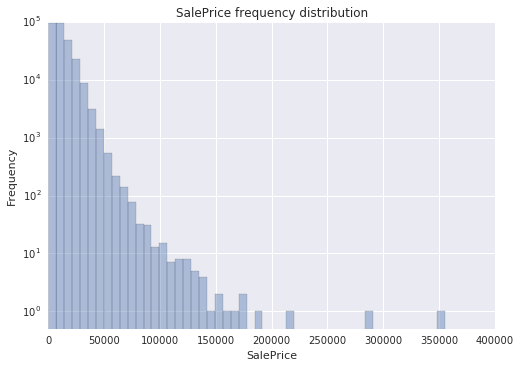

In [13]:
# SalePrice
# Plot frequency distribution.
sns.distplot(df['SalePrice'].values, hist=True, kde=False, norm_hist=False)
plt.title('SalePrice frequency distribution')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.yscale('log')
plt.ylim(ymin=0.5)
plt.show()

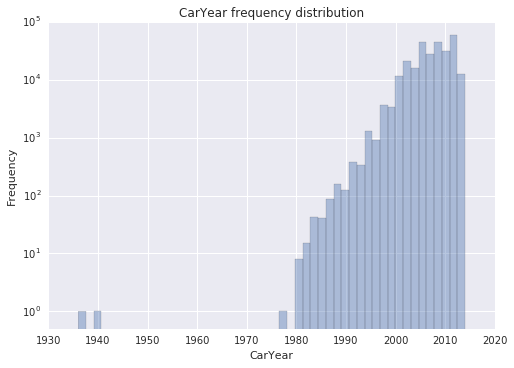

In [14]:
# CarYear
# Plot frequency distribution.
sns.distplot(df['CarYear'].values, hist=True, kde=False, norm_hist=False)
plt.title('CarYear frequency distribution')
plt.xlabel('CarYear')
plt.ylabel('Frequency')
plt.yscale('log')
plt.ylim(ymin=0.5)
plt.show()

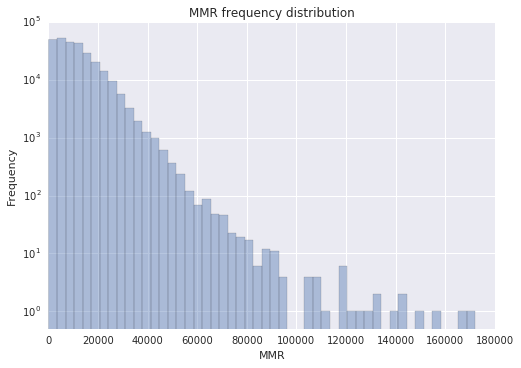

In [15]:
# MMR

# Plot frequency distribution.
sns.distplot(df['MMR'].values, hist=True, kde=False, norm_hist=False)
plt.title('MMR frequency distribution')
plt.xlabel('MMR')
plt.ylabel('Frequency')
plt.yscale('log')
plt.ylim(ymin=0.5)
plt.show()

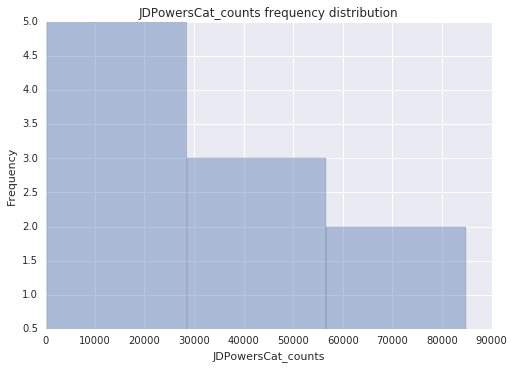

In [16]:
# JDPowersCat
# TODO: Estimate sizes from Wikipedia, e.g. https://en.wikipedia.org/wiki/Vehicle_size_class.

# Cast to string, replacing 'nan' with 'UNKNOWN'.
df['JDPowersCat'] = (df['JDPowersCat'].astype(str)).str.replace(' ', '').apply(
    lambda cat: 'UNKNOWN' if cat == 'nan' else cat)

# One-hot encoding.
df = pd.merge(
    left=df,
    right=pd.get_dummies(df['JDPowersCat'], prefix='JDPowersCat'),
    left_index=True,
    right_index=True)

# Plot frequency distrbution.
jdpowerscat_counts = collections.Counter(df['JDPowersCat'].values)
sns.distplot(list(jdpowerscat_counts.values()), hist=True, kde=False, norm_hist=False)
plt.title('JDPowersCat_counts frequency distribution')
plt.xlabel('JDPowersCat_counts')
plt.ylabel('Frequency')
plt.ylim(ymin=0.5)
plt.show()

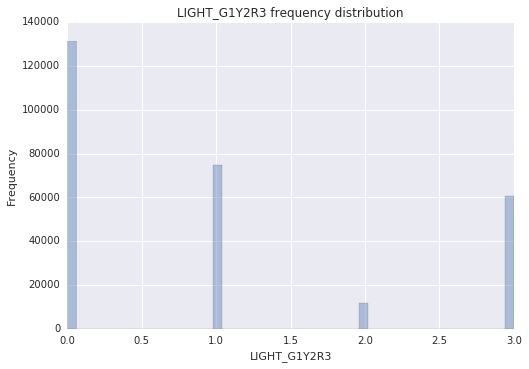

In [17]:
# LIGHTG, LIGHTY, LIGHTR, LIGHT_G1Y2R3

# Fix all transactions so that only light with highest warning is retained.
df.loc[df['LIGHTR']==1, ['LIGHTG', 'LIGHTY']] = 0
df.loc[df['LIGHTY']==1, ['LIGHTG']] = 0

# Rank lights by warning level: null=0, green=1, yellow=2, red=3
df['LIGHT_G1Y2R3'] = df['LIGHTG']*1 + df['LIGHTY']*2 + df['LIGHTR']*3

# Plot frequency distrbution.
sns.distplot(df['LIGHT_G1Y2R3'].values, hist=True, kde=False, norm_hist=False)
plt.title('LIGHT_G1Y2R3 frequency distribution')
plt.xlabel('LIGHT_G1Y2R3')
plt.ylabel('Frequency')
plt.show()

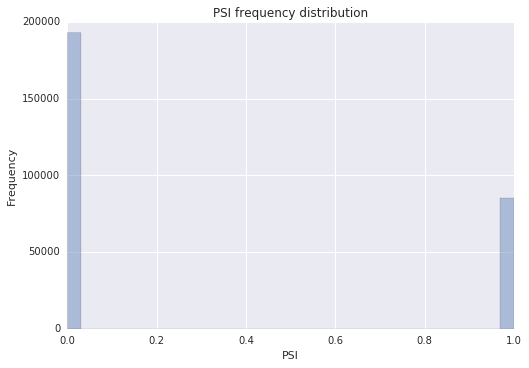

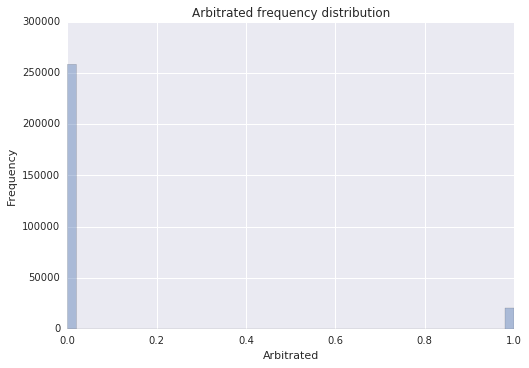

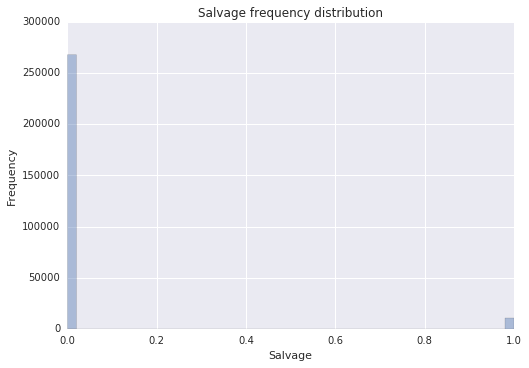

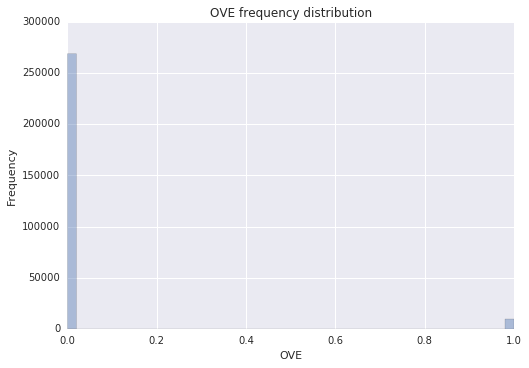

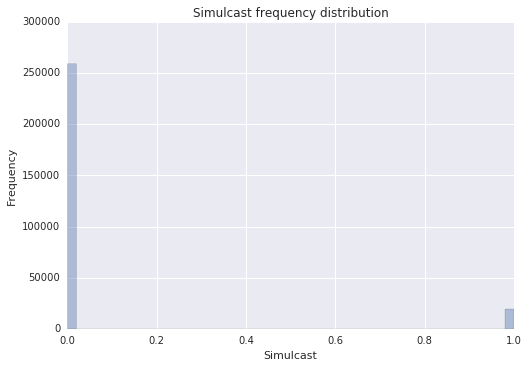

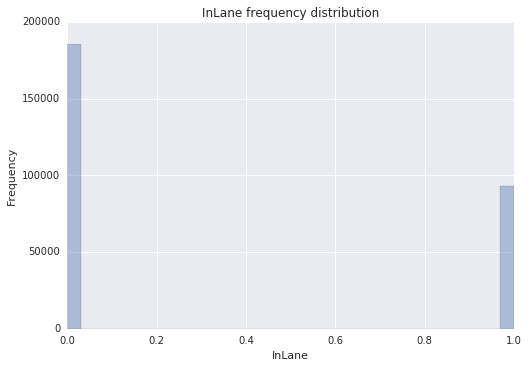

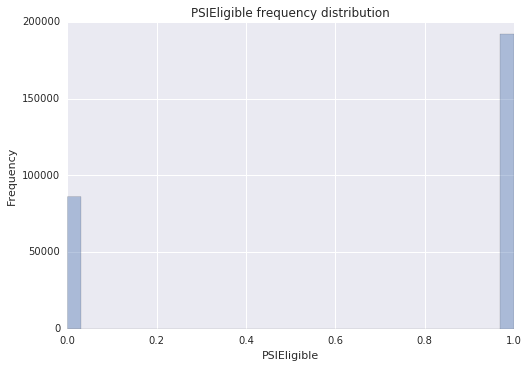

In [18]:
# PSI, Arbitrated, Salvage, OVE, Simulcast, InLane, PSIEligible

# Plot frequency distrbution.
for col in ['PSI', 'Arbitrated', 'Salvage', 'OVE', 'Simulcast', 'InLane', 'PSIEligible']:
    sns.distplot(df[col].values, hist=True, kde=False, norm_hist=False)
    plt.title('{col} frequency distribution'.format(col=col))
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

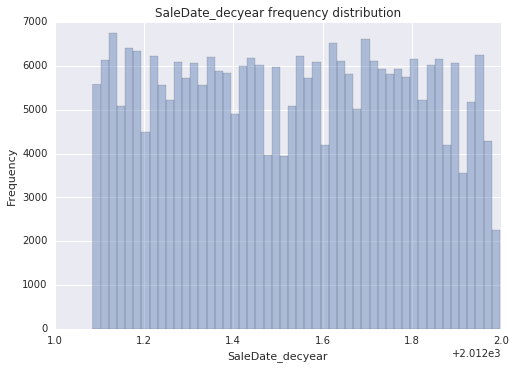

In [19]:
# SaleDate, SaleDate_dow, SaleDate_doy, SaleDate_day, SaleDate_decyear

# Cast SaleDate to pandas.timestamp and create features.
df['SaleDate'] = pd.to_datetime(df['SaleDate'], format=r'%y-%m-%d')
df['SaleDate_dow'] = df['SaleDate'].dt.dayofweek
df['SaleDate_doy'] = df['SaleDate'].dt.dayofyear
df['SaleDate_day'] = df['SaleDate'].dt.day
df['SaleDate_decyear'] = df['SaleDate'].dt.year + (df['SaleDate'].dt.dayofyear-1)/366

# Plot frequency distrbution.
sns.distplot(df['SaleDate_decyear'].values, hist=True, kde=False, norm_hist=False)
plt.title('SaleDate_decyear frequency distribution')
plt.xlabel('SaleDate_decyear')
plt.ylabel('Frequency')
plt.show()

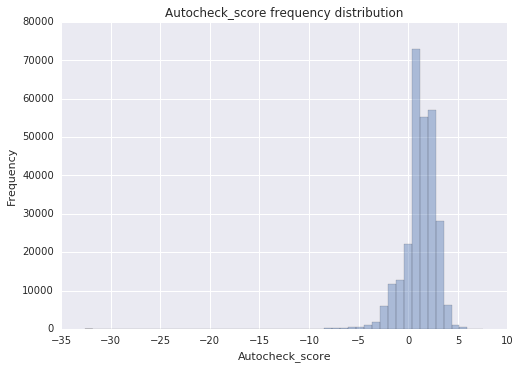

In [20]:
# Autocheck_score
# TODO: Use nearest neighbors to infer probable fill value.

# Fill null values with mode (1.0).
df['Autocheck_score'] = df['Autocheck_score'].fillna(value=1.0)

# Plot frequency distrbution.
sns.distplot(df['Autocheck_score'].values, hist=True, kde=False, norm_hist=False)
plt.title('Autocheck_score frequency distribution')
plt.xlabel('Autocheck_score')
plt.ylabel('Frequency')
plt.show()

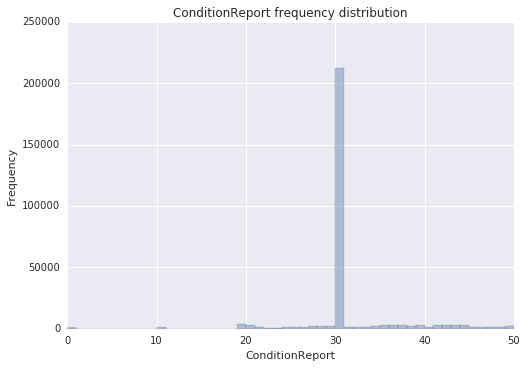

In [21]:
# ConditionReport

# Map character codes to numerical values, invalid codes are "average".
conrpt_value = {
    'EC': 50,
    'CL': 40,
    'AV': 30,
    'RG': 20,
    'PR': 10,
    'SL': 0,
    'A': 30,
    'A3': 30,
    'Y6': 30,
    'nan': 30}
df['ConditionReport'] = df['ConditionReport'].astype(str).apply(
    lambda con: conrpt_value[con] if con in conrpt_value else con)
df['ConditionReport'] = df['ConditionReport'].astype(int)

# Plot frequency distrbution.
sns.distplot(df['ConditionReport'].values, hist=True, kde=False, norm_hist=False)
plt.title('ConditionReport frequency distribution')
plt.xlabel('ConditionReport')
plt.ylabel('Frequency')
plt.show()

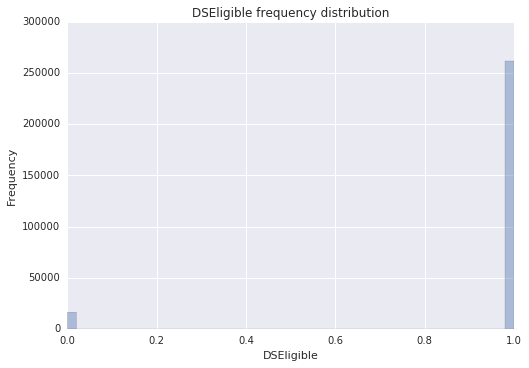

In [22]:
# DSEligible

# Plot frequency distrbution.
sns.distplot(df['DSEligible'].values, hist=True, kde=False, norm_hist=False)
plt.title('DSEligible frequency distribution')
plt.xlabel('DSEligible')
plt.ylabel('Frequency')
plt.show()

In [23]:
# Compare DSEligible and Returned

pd.pivot_table(
    df[['DSEligible', 'Returned']].astype(str), index='DSEligible', columns='Returned',
    aggfunc=len, margins=True, dropna=False)

Returned,0.0,1.0,nan,All
DSEligible,,,,
0,542.0,291.0,15343.0,16176.0
1,14984.0,3876.0,243301.0,262161.0
All,15526.0,4167.0,258644.0,278337.0


In [24]:
# Some vehicles have DSEligible=0 but have Returned!=nan due to errors or extenuating circumstances.
# To correct: If Returned!=nan, then DSEligible=1
df.loc[df['Returned'].notnull(), 'DSEligible'] = 1

pd.pivot_table(
    df[['DSEligible', 'Returned']].astype(str), index='DSEligible', columns='Returned',
    aggfunc=len, margins=True, dropna=False)

Returned,0.0,1.0,nan,All
DSEligible,,,,
0,NaN,NaN,15343.0,15343.0
1,15526.0,4167.0,243301.0,262994.0
All,15526.0,4167.0,258644.0,278337.0


In [25]:
# Some vehicles have DSEligible=0 but have Returned!=nan due to errors or extenuating circumstances.
# To correct: If Returned!=nan, then DSEligible=1
df.loc[df['Returned'].notnull(), 'DSEligible'] = 1

pd.pivot_table(
    df[['DSEligible', 'Returned']].astype(str), index='DSEligible', columns='Returned',
    aggfunc=len, margins=True, dropna=False)

Returned,0.0,1.0,nan,All
DSEligible,,,,
0,NaN,NaN,15343.0,15343.0
1,15526.0,4167.0,243301.0,262994.0
All,15526.0,4167.0,258644.0,278337.0


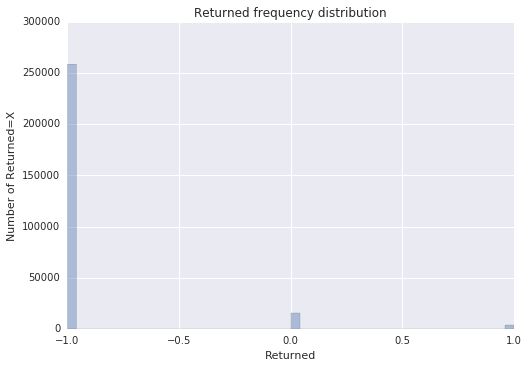

Returned,-1,0,1,All
DSEligible,,,,
0,15343.0,NaN,NaN,15343.0
1,243301.0,15526.0,4167.0,262994.0
All,258644.0,15526.0,4167.0,278337.0


In [26]:
# Returned

# Fill null values with -1 and cast to int.
df['Returned'] = df[['Returned']].fillna(value=-1).astype(int)

# Plot frequency distrbution.
sns.distplot(df['Returned'].values, hist=True, kde=False, norm_hist=False)
plt.title('Returned frequency distribution')
plt.xlabel('Returned')
plt.ylabel('Number of Returned=X')
plt.show()

pd.pivot_table(
    df[['DSEligible', 'Returned']].astype(str), index='DSEligible', columns='Returned',
    aggfunc=len, margins=True, dropna=False)

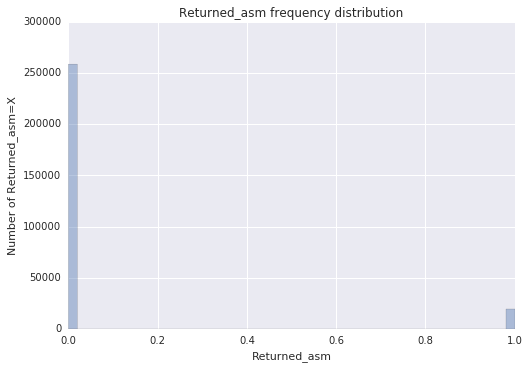

Returned_asm,0,1,All
DSEligible,,,
0,NaN,15343.0,15343.0
1,258827.0,4167.0,262994.0
All,258827.0,19510.0,278337.0


In [27]:
# Returned_asm

# Interpretation of assumptions:
# If DSEligible=0, then the vehicle is not eligible for a guarantee.
# * And Returned=-1 (null) since we don't know whether or not it would have been returned,
#   but given that it wasn't eligible, it may have been likely to have Returned=1.
# If DSEligible=1, then the vehicle is eligible for a guarantee.
# * And if Returned=0 then the guarantee was purchased and the vehicle was not returned.
# * And if Returned=1 then the guarantee was purchased and the vehicle was returned.
# * And if Returned=-1 (null) then the guarantee was not purchased.
#   We don't know whether or not it would have been returned,
#   but given that the dealer did not purchase, it may have been likely to have Returned=0.

# Assume:
# If Returned=-1 and DSEligible=0, then Returned_asm=1
# If Returned=-1 and DSEligible=1, then Returned_asm=0
df['Returned_asm'] = df['Returned']
df.loc[
    np.logical_and(
        df['Returned'] == -1,
        df['DSEligible'] == 0),
    'Returned_asm'] = 1
df.loc[
    np.logical_and(
        df['Returned'] == -1,
        df['DSEligible'] == 1),
    'Returned_asm'] = 0

# Plot frequency distrbution.
sns.distplot(df['Returned_asm'].values, hist=True, kde=False, norm_hist=False)
plt.title('Returned_asm frequency distribution')
plt.xlabel('Returned_asm')
plt.ylabel('Number of Returned_asm=X')
plt.show()

pd.pivot_table(
    df[['DSEligible', 'Returned_asm']].astype(str), index='DSEligible', columns='Returned_asm',
    aggfunc=len, margins=True, dropna=False)

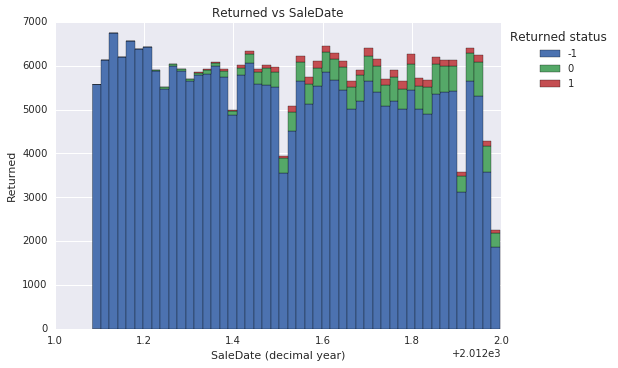

In [121]:
df_plot = df[['SaleDate_decyear', 'Returned']].copy()
itemized_counts = {
    ret: collections.Counter(grp['SaleDate_decyear'])
    for (ret, grp) in df_plot.groupby(by='Returned')}
itemized_counts = collections.OrderedDict(
    sorted(itemized_counts.items(), key=lambda tup: tup[0]))

# Plot timeseries histogram.
keys = itemized_counts.keys()
bins = int(np.ceil((df_plot['SaleDate_decyear'].max() - df_plot['SaleDate_decyear'].min())/(1.0/52.0)))
colors = sns.color_palette(n_colors=len(keys))
plt.hist(
    [list(itemized_counts[key].elements()) for key in itemized_counts.keys()],
    bins=bins, stacked=True, rwidth=1.0, label=keys, color=colors)
plt.title('Returned vs SaleDate')
plt.xlabel('SaleDate (decimal year)')
plt.ylabel('Returned')
plt.legend(title='Returned status', loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

del df_plot

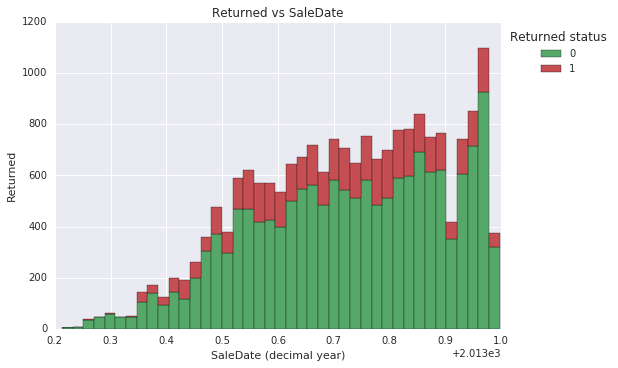

In [123]:
df_plot = df.loc[df['Returned']!=-1, ['SaleDate_decyear', 'Returned']].copy()
itemized_counts = {
    ret: collections.Counter(grp['SaleDate_decyear'])
    for (ret, grp) in df_plot.groupby(by='Returned')}
itemized_counts = collections.OrderedDict(
    sorted(itemized_counts.items(), key=lambda tup: tup[0]))

# Plot timeseries histogram.
keys = itemized_counts.keys()
bins = int(np.ceil((df_plot['SaleDate_decyear'].max() - df_plot['SaleDate_decyear'].min())/(1.0/52.0)))
plt.hist(
    [list(itemized_counts[key].elements()) for key in itemized_counts.keys()],
    bins=bins, stacked=True, rwidth=1.0, label=keys, color=colors[-2:])
plt.title('Returned vs SaleDate')
plt.xlabel('SaleDate (decimal year)')
plt.ylabel('Returned')
plt.legend(title='Returned status', loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

del df_plot

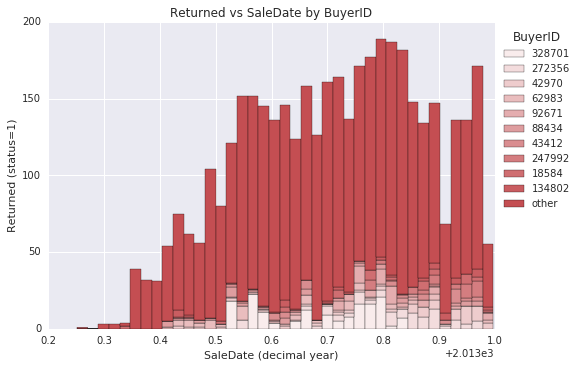

In [178]:
df_plot = df.loc[df['Returned']==1, ['SaleDate_decyear', 'BuyerID']].copy()
top = [tup[0] for tup in collections.Counter(df_plot['BuyerID']).most_common(n=10)]
itemized_counts_all = {
    buy: collections.Counter(grp['SaleDate_decyear'])
    for (buy, grp) in df_plot.groupby(by='BuyerID')}
itemized_counts_top = {'other': collections.Counter()}
for (buyerid, counts) in itemized_counts_all.items():
    if buyerid in top:
        itemized_counts_top[buyerid] = counts
    else:
        itemized_counts_top['other'].update(counts)
itemized_counts = collections.OrderedDict(
    sorted(itemized_counts_top.items(), key=lambda tup: sum(tup[1].values()), reverse=True))
itemized_counts.move_to_end('other')

# Plot timeseries histogram.
keys = itemized_counts.keys()
bins = int(np.ceil((df_plot['SaleDate_decyear'].max() - df_plot['SaleDate_decyear'].min())/(1.0/52.0)))
colors = sns.light_palette(sns.color_palette()[2], n_colors=len(keys))
plt.hist(
    [list(itemized_counts[key].elements()) for key in itemized_counts.keys()],
    bins=bins, stacked=True, rwidth=1.0, label=keys, color=colors)
plt.title('Returned vs SaleDate by BuyerID')
plt.xlabel('SaleDate (decimal year)')
plt.ylabel('Returned (status=1)')
plt.legend(title='BuyerID', loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

del df_plot

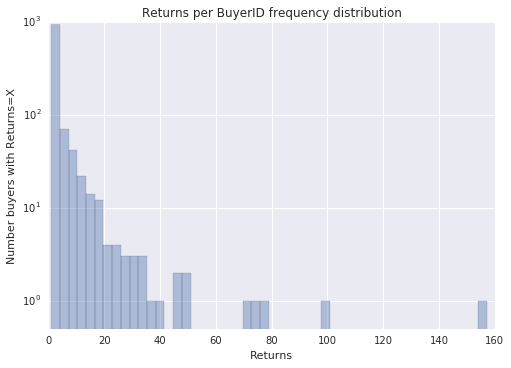

In [183]:
# Plot frequency distribution
return_counts = collections.Counter(df.loc[df['Returned']==1, 'BuyerID'].values)
sns.distplot(list(return_counts.values()), hist=True, kde=False, norm_hist=False)
plt.title('Returns per BuyerID frequency distribution')
plt.xlabel('Returns')
plt.ylabel('Number buyers with Returns=X')
plt.yscale('log')
plt.ylim(ymin=0.5)
plt.show()

In [51]:
df.dtypes.iloc[0:20]

BuyerID            object
SellerID           object
Mileage             int64
VIN                object
SellingLocation    object
CarMake            object
SalePrice           int64
CarYear             int64
MMR                 int64
JDPowersCat        object
LIGHTG              int64
LIGHTY              int64
LIGHTR              int64
PSI                 int64
Arbitrated          int64
Salvage             int64
OVE                 int64
Simulcast           int64
InLane              int64
PSIEligible         int64
dtype: object

In [50]:
df.dtypes.iloc[20:40]

SaleDate                  datetime64[ns]
Autocheck_score                  float64
ConditionReport                    int64
DSEligible                         int64
Returned                           int64
BuyerID_counts                     int64
SellerID_counts                    int64
VIN_counts                         int64
SellingLocation_counts             int64
SellingLocation_lat              float64
SellingLocation_lon              float64
SellingLocation_AAA              float64
SellingLocation_AAAI             float64
SellingLocation_AAAW             float64
SellingLocation_ALBA             float64
SellingLocation_ALOH             float64
SellingLocation_AREN             float64
SellingLocation_AYCA             float64
SellingLocation_BAA              float64
SellingLocation_BCAA             float64
dtype: object

In [141]:
df.describe(include='all')

/opt/conda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,BuyerID,SellerID,Mileage,VIN,SellingLocation,CarMake,SalePrice,CarYear,MMR,JDPowersCat,...,Autocheck_score,ConditionReport,DSEligible,Returned,SellingLocation_lat,SellingLocation_lon,BuyerID_counts,SellerID_counts,VIN_counts,SellingLocation_counts
count,278337.000000,278337.000000,278337.000000,278337,278337,278335,278337.000000,278337.000000,278337.000000,277981,...,269017.000000,70005,278337.000000,19693.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000,278337.000000
unique,NaN,NaN,NaN,268465,67,200,NaN,NaN,NaN,9,...,NaN,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,4T1BK36B38U260664,THAA,FORD,NaN,NaN,NaN,SUV,...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,6,41994,47072,NaN,NaN,NaN,84831,...,NaN,3507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,183195.207784,297626.938797,84228.544933,NaN,NaN,NaN,11973.232032,2007.407140,11388.524882,NaN,...,1.205120,NaN,0.941883,0.211598,34.338469,-87.579034,927.095769,1015.683064,1.076159,17463.171382
std,113415.181921,134761.222715,54879.931708,NaN,NaN,NaN,9083.860494,3.956124,9025.527367,NaN,...,1.744673,NaN,0.233964,0.408452,4.338165,9.354517,1457.858523,1729.899977,0.296490,13560.750162
min,329.000000,0.000000,1.000000,NaN,NaN,NaN,1.000000,1936.000000,0.000000,NaN,...,-32.599998,NaN,0.000000,0.000000,21.342331,-157.894707,1.000000,1.000000,1.000000,2.000000
25%,78794.000000,204652.000000,38778.000000,NaN,NaN,NaN,5600.000000,2005.000000,4775.000000,NaN,...,NaN,NaN,1.000000,NaN,29.644441,-95.305058,111.000000,36.000000,1.000000,6132.000000
50%,176870.000000,324162.000000,79599.000000,NaN,NaN,NaN,10100.000000,2008.000000,9700.000000,NaN,...,NaN,NaN,1.000000,NaN,34.294595,-86.444251,267.000000,197.000000,1.000000,14596.000000
75%,295757.000000,432754.000000,114088.000000,NaN,NaN,NaN,16000.000000,2011.000000,15750.000000,NaN,...,NaN,NaN,1.000000,NaN,38.399463,-79.894945,820.000000,1065.000000,1.000000,31305.000000


In [ ]:
# TODO
# Determine which features are categorical and plot.
# Features are considered "categorical" if
# num_unique_feature_values < min(num_unique_id_values, num_unique_target_values)
(df_ftrs, ds_trg) = (step.s2.dfs.df_features_model, step.s2.dfs.ds_target_model)
(nuniq_uid, nuniq_trg) = (len(df_ftrs['SERIALNO'].unique()), len(ds_trg.unique()))
nuniq_min = min(nuniq_uid, nuniq_trg)
(ftr_nuniq, nuniq_nftrs, cat_ftrs) = (dict(), collections.defaultdict(int), list())
for ftr in df_ftrs.columns:
    ftr_nuniq[ftr] = len(df_ftrs[ftr].unique())
for (ftr, nuniq) in ftr_nuniq.items():
    nuniq_nftrs[nuniq] += 1
    if 1 < nuniq < nuniq_min:
        cat_ftrs.append(ftr)
nuniq_nftrs = np.asarray(sorted(nuniq_nftrs.items()))
tfmask = np.logical_and(1 < nuniq_nftrs[:, 0], nuniq_nftrs[:, 0] < nuniq_min)
nuniq_nftrs_cat = nuniq_nftrs[tfmask]
if not np.sum(nuniq_nftrs_cat[:, 1]) == len(cat_ftrs):
    raise AssertionError(
        ("Program error. The tallies of categorical features do not match.\n" +
         "Required: np.sum(nuniq_nftrs_cat[:, 1]) == len(cat_ftrs)\n" +
         "Given: {lhs} == {rhs}").format(
            lhs=np.sum(nuniq_nftrs_cat[:, 1]), rhs=len(cat_ftrs)))
print(
    ("Features are considered 'categorical' if num_unique_feature_values\n" +
     "    < min(num_unique_id_values ({uid}), num_unique_target_values ({trg}))\n" +
     "    = min({nuid}, {ntrg}) = {nmin}\n" +
     "Percent of features that are categorical: {frac:.1%}").format(
        uid='SERIALNO', trg=step.s0.dfs.ds_target_model.name,
        nuid=nuniq_uid, ntrg=nuniq_trg, nmin=nuniq_min,
        frac=len(cat_ftrs)/len(df_ftrs.columns)))
plt.semilogx(
    nuniq_nftrs[:, 0], nuniq_nftrs[:, 1], marker='.', linestyle='-',
    color=sns.color_palette()[0], label='features')
plt.semilogx(
    nuniq_nftrs_cat[:, 0], nuniq_nftrs_cat[:, 1], marker='o', linestyle='',
    color=sns.color_palette('dark')[0], label='categorical features')
plt.axvline(
    x=len(step.s2.dfs.ds_target_model.unique()),
    color=sns.color_palette()[1], label=step.s2.dfs.ds_target_model.name)
plt.axvline(
    x=len(step.s2.dfs.df_features_model['SERIALNO'].unique()),
    color=sns.color_palette()[2], label='SERIALNO')
plt.title("Number of feature vs number of unique values per feature")
plt.xlabel("Number of unique values per feature")
plt.ylabel("Number of features")
plt.legend(loc='upper center')
plt.show()